In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [4]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPooling2D, LSTM, TimeDistributed, Reshape
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.applications import ResNet50, MobileNetV2
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import random
import warnings
warnings.filterwarnings('ignore')

# Check for available GPUs and set memory growth
physical_devices = tf.config.list_physical_devices('GPU')
print(f"Available GPUs: {len(physical_devices)}")
for device in physical_devices:
    tf.config.experimental.set_memory_growth(device, True)

# Set random seeds for reproducibility
SEED = 42
np.random.seed(SEED)
tf.random.set_seed(SEED)
random.seed(SEED)

# Dataset paths
DATASET_PATH = '/kaggle/input/new-plant-diseases-dataset'
TRAIN_PATH = os.path.join(DATASET_PATH,'New Plant Diseases Dataset(Augmented)/New Plant Diseases Dataset(Augmented)/train/')
VALID_PATH = os.path.join(DATASET_PATH, 'New Plant Diseases Dataset(Augmented)/New Plant Diseases Dataset(Augmented)/valid/')
TEST_PATH = os.path.join(DATASET_PATH, 'test/test')

# Explore the dataset structure
def explore_dataset(path):
    classes = os.listdir(path)
    class_counts = {}
    for class_name in classes:
        class_path = os.path.join(path, class_name)
        if os.path.isdir(class_path):
            count = len(os.listdir(class_path))
            class_counts[class_name] = count
    return class_counts

print("Exploring dataset structure...")
train_classes = explore_dataset(TRAIN_PATH)
print(f"Total number of classes: {len(train_classes)}")
print(f"Total number of training images: {sum(train_classes.values())}")

Available GPUs: 2
Exploring dataset structure...
Total number of classes: 38
Total number of training images: 70295


Displaying sample images from training set:


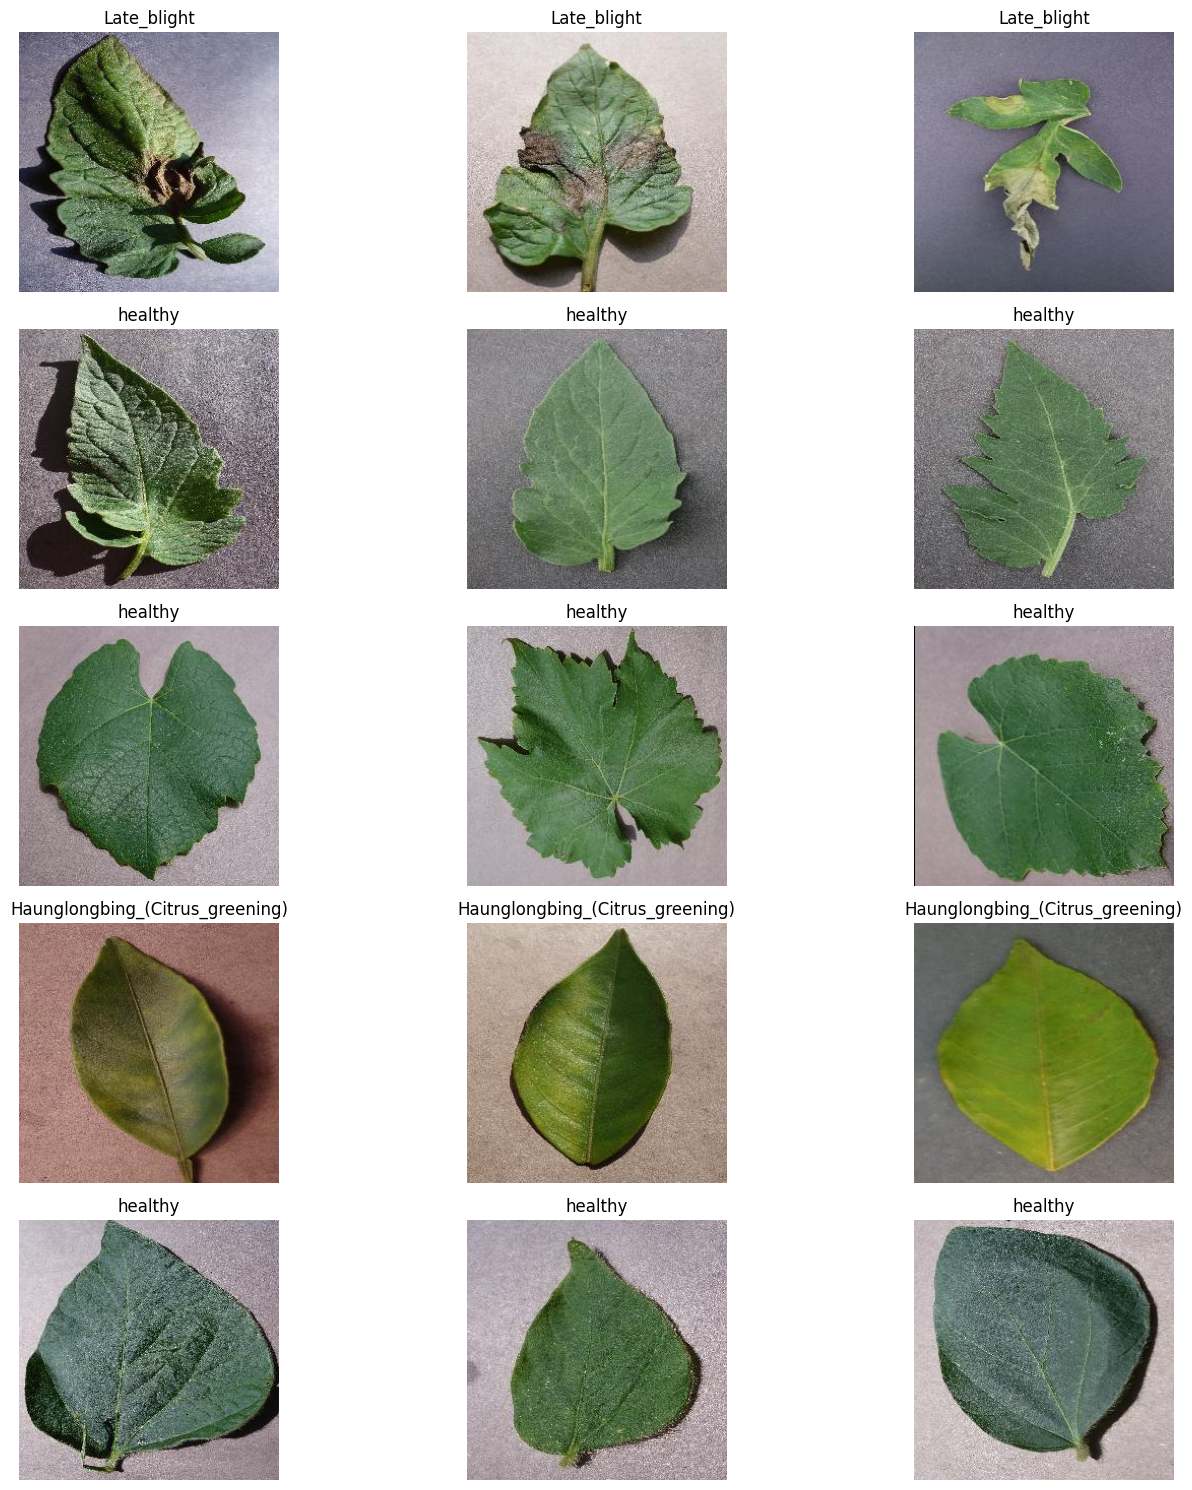

In [5]:
def plot_sample_images(path, num_classes=5, samples_per_class=3):
    classes = list(os.listdir(path))[:num_classes]
    fig, axes = plt.subplots(num_classes, samples_per_class, figsize=(15, 3*num_classes))
    
    for i, class_name in enumerate(classes):
        class_path = os.path.join(path, class_name)
        if os.path.isdir(class_path):
            images = os.listdir(class_path)[:samples_per_class]
            for j, img_name in enumerate(images):
                img_path = os.path.join(class_path, img_name)
                img = plt.imread(img_path)
                axes[i, j].imshow(img)
                axes[i, j].set_title(class_name.split('___')[-1] if '___' in class_name else class_name)
                axes[i, j].axis('off')
    
    plt.tight_layout()
    plt.show()

print("Displaying sample images from training set:")
plot_sample_images(TRAIN_PATH)

In [6]:
# Image dimensions
IMG_WIDTH, IMG_HEIGHT = 224, 224
BATCH_SIZE = 32

# Data augmentation for training
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

# Only rescale for validation and testing
valid_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

# Create data generators
train_generator = train_datagen.flow_from_directory(
    TRAIN_PATH,
    target_size=(IMG_WIDTH, IMG_HEIGHT),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=True
)

valid_generator = valid_datagen.flow_from_directory(
    VALID_PATH,
    target_size=(IMG_WIDTH, IMG_HEIGHT),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False
)

# For test data if available
try:
    test_generator = test_datagen.flow_from_directory(
        TEST_PATH,
        target_size=(IMG_WIDTH, IMG_HEIGHT),
        batch_size=BATCH_SIZE,
        class_mode='categorical',
        shuffle=False
    )
    test_data_available = True
except:
    test_data_available = False
    print("Test directory structure not found. Will use validation data for testing.")

# Get class indices and mapping
class_indices = train_generator.class_indices
class_names = list(class_indices.keys())
num_classes = len(class_indices)
print(f"Number of classes: {num_classes}")

Found 70295 images belonging to 38 classes.
Found 17572 images belonging to 38 classes.
Found 33 images belonging to 1 classes.
Number of classes: 38


Original and augmented images:


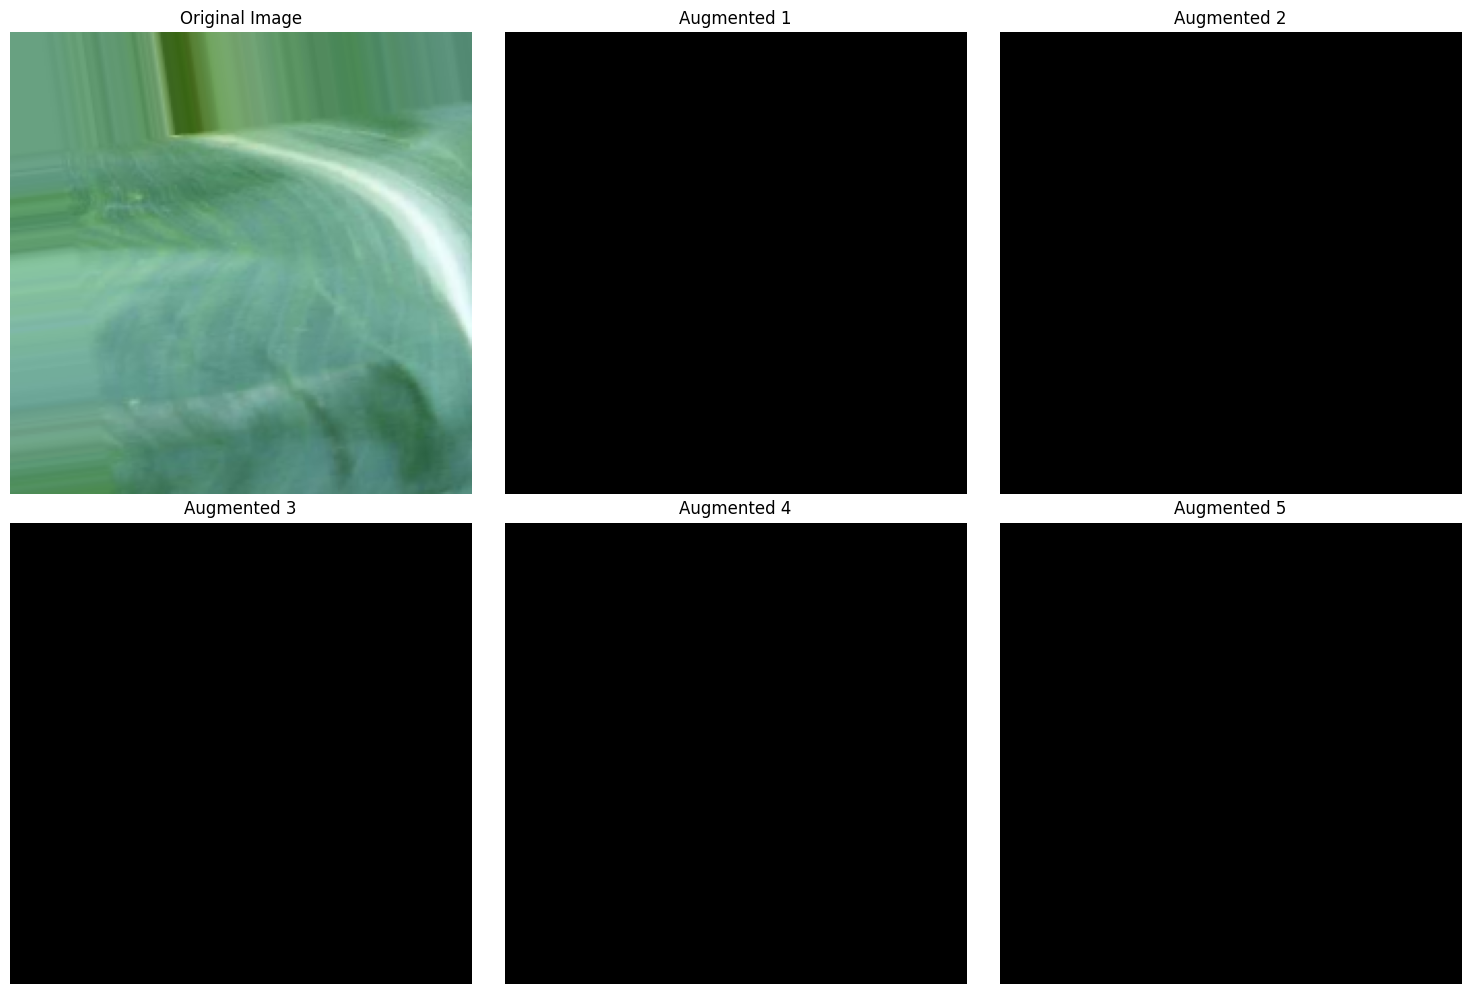

In [7]:
def show_augmented_images(datagen, original_image, num_rows=2, num_cols=3):
    # Get one batch of original images
    fig, axes = plt.subplots(num_rows, num_cols, figsize=(15, 10))
    axes = axes.flatten()
    
    # Display original image
    axes[0].imshow(original_image)
    axes[0].set_title('Original Image')
    axes[0].axis('off')
    
    # Generate augmented images
    img = np.expand_dims(original_image, 0)
    aug_iter = datagen.flow(img, batch_size=1)
    
    # Display augmented images
    for i in range(1, num_rows*num_cols):
        # Use __next__() instead of next()
        aug_img = next(aug_iter)[0]  # This is the correct way to call next in Python 3
        axes[i].imshow(aug_img)
        axes[i].set_title(f'Augmented {i}')
        axes[i].axis('off')
    
    plt.tight_layout()
    plt.show()

# Get a sample image
sample_batch = next(iter(train_generator))
sample_image = sample_batch[0][0]

print("Original and augmented images:")
show_augmented_images(train_datagen, sample_image)

In [8]:
def build_cnn_lstm_model(input_shape, num_classes):
    # CNN part
    cnn_model = Sequential([
        Conv2D(32, (3, 3), activation='relu', input_shape=input_shape),
        MaxPooling2D(pool_size=(2, 2)),
        Conv2D(64, (3, 3), activation='relu'),
        MaxPooling2D(pool_size=(2, 2)),
        Conv2D(128, (3, 3), activation='relu'),
        MaxPooling2D(pool_size=(2, 2)),
        Conv2D(256, (3, 3), activation='relu'),
        MaxPooling2D(pool_size=(2, 2))
    ])
    
    # LSTM part
    model = Sequential([
        cnn_model,
        Reshape((-1, 256)),  # Reshape for LSTM input
        LSTM(256, return_sequences=True),
        LSTM(128),
        Dense(512, activation='relu'),
        Dropout(0.5),
        Dense(num_classes, activation='softmax')
    ])
    
    model.compile(
        optimizer='adam',
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )
    
    return model

# Build the model
input_shape = (IMG_WIDTH, IMG_HEIGHT, 3)
model = build_cnn_lstm_model(input_shape, num_classes)
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ sequential (Sequential)              │ (None, 12, 12, 256)         │         388,416 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ reshape (Reshape)                    │ (None, 144, 256)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm (LSTM)                          │ (None, 144, 256)            │         525,312 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_1 (LSTM)                        │ (None, 128)                 │         197,120 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 512)                 │          66,048 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 38)                  │          19,494 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,196,390 (4.56 MB)

 Trainable params: 1,196,390 (4.56 MB)

 Non-trainable params: 0 (0.00 B)

In [9]:
# Define callbacks
checkpoint = ModelCheckpoint(
    'best_model.keras',
    monitor='val_accuracy',
    save_best_only=True,
    mode='max',
    verbose=1
)

early_stopping = EarlyStopping(
    monitor='val_accuracy',
    patience=10,
    restore_best_weights=True,
    verbose=1
)

# Calculate steps per epoch
steps_per_epoch = train_generator.samples // BATCH_SIZE
validation_steps = valid_generator.samples // BATCH_SIZE

# Train the model
history = model.fit(
    train_generator,
    steps_per_epoch=steps_per_epoch,
    epochs=30,
    validation_data=valid_generator,
    validation_steps=validation_steps,
    callbacks=[checkpoint, early_stopping]
)

Epoch 1/30
2196/2196 ━━━━━━━━━━━━━━━━━━━━ 0s 585ms/step - accuracy: 0.0805 - loss: 3.3346
Epoch 1: val_accuracy improved from -inf to 0.36151, saving model to best_model.keras
2196/2196 ━━━━━━━━━━━━━━━━━━━━ 1531s 692ms/step - accuracy: 0.0806 - loss: 3.3344 - val_accuracy: 0.3615 - val_loss: 2.1682
Epoch 2/30
   1/2196 ━━━━━━━━━━━━━━━━━━━━ 3:51 105ms/step - accuracy: 0.3125 - loss: 2.3469
Epoch 2: val_accuracy improved from 0.36151 to 0.75000, saving model to best_model.keras
2196/2196 ━━━━━━━━━━━━━━━━━━━━ 0s 162us/step - accuracy: 0.3125 - loss: 2.3469 - val_accuracy: 0.7500 - val_loss: 1.4581
Epoch 3/30
2196/2196 ━━━━━━━━━━━━━━━━━━━━ 0s 385ms/step - accuracy: 0.4723 - loss: 1.7267
Epoch 3: val_accuracy did not improve from 0.75000
2196/2196 ━━━━━━━━━━━━━━━━━━━━ 887s 403ms/step - accuracy: 0.4723 - loss: 1.7266 - val_accuracy: 0.6968 - val_loss: 0.9413
Epoch 4/30
   1/2196 ━━━━━━━━━━━━━━━━━━━━ 2:38 72ms/step - accuracy: 0.5938 - loss: 1.2390
Epoch 4: val_accuracy improved from 0.75000

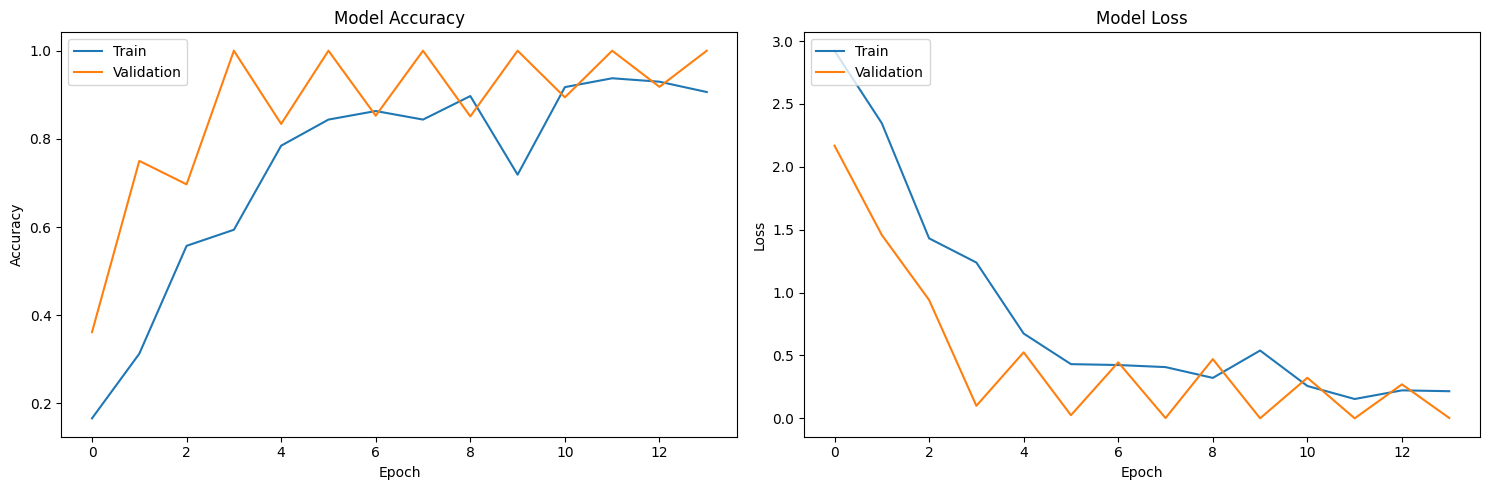

In [10]:
# Plot training history
def plot_training_history(history):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
    
    # Accuracy plot
    ax1.plot(history.history['accuracy'])
    ax1.plot(history.history['val_accuracy'])
    ax1.set_title('Model Accuracy')
    ax1.set_ylabel('Accuracy')
    ax1.set_xlabel('Epoch')
    ax1.legend(['Train', 'Validation'], loc='upper left')
    
    # Loss plot
    ax2.plot(history.history['loss'])
    ax2.plot(history.history['val_loss'])
    ax2.set_title('Model Loss')
    ax2.set_ylabel('Loss')
    ax2.set_xlabel('Epoch')
    ax2.legend(['Train', 'Validation'], loc='upper left')
    
    plt.tight_layout()
    plt.show()

plot_training_history(history)

In [ ]:
# Evaluate on validation set
print("Evaluating on validation set...")
val_loss, val_accuracy = model.evaluate(valid_generator, steps=validation_steps)
print(f"Validation Loss: {val_loss:.4f}")
print(f"Validation Accuracy: {val_accuracy:.4f}")

# Get predictions
valid_generator.reset()
y_pred = model.predict(valid_generator, steps=validation_steps)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = valid_generator.classes[:len(y_pred_classes)]

# Classification report
print("Classification Report:")
report = classification_report(y_true, y_pred_classes, target_names=class_names, output_dict=True)
report_df = pd.DataFrame(report).transpose()
print(report_df)

# Confusion matrix
plt.figure(figsize=(12, 10))
cm = confusion_matrix(y_true, y_pred_classes)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.title('Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.xticks(rotation=90)
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

Evaluating on validation set...
549/549 ━━━━━━━━━━━━━━━━━━━━ 36s 65ms/step - accuracy: 0.6931 - loss: 0.9246
Validation Loss: 0.9343
Validation Accuracy: 0.7000
549/549 ━━━━━━━━━━━━━━━━━━━━ 34s 61ms/step
Classification Report:
                                                    precision    recall  \
Apple___Apple_scab                                   0.822581  0.505952   
Apple___Black_rot                                    0.542974  0.800805   
Apple___Cedar_apple_rust                             0.715084  0.581818   
Apple___healthy                                      0.662069  0.573705   
Blueberry___healthy                                  0.675302  0.861233   
Cherry_(including_sour)___Powdery_mildew             0.624714  0.648456   
Cherry_(including_sour)___healthy                    0.871369  0.460526   
Corn_(maize)___Cercospora_leaf_spot Gray_leaf_spot   0.800654  0.597561   
Corn_(maize)___Common_rust_                          0.979036  0.979036   
Corn_(maize)___Northern

In [ ]:
def plot_predictions(generator, model, num_samples=10):
    generator.reset()
    batch_x, batch_y = next(generator)
    preds = model.predict(batch_x)
    
    plt.figure(figsize=(15, 20))
    for i in range(min(num_samples, len(batch_x))):
        plt.subplot(5, 2, i+1)
        plt.imshow(batch_x[i])
        
        true_class = np.argmax(batch_y[i])
        pred_class = np.argmax(preds[i])
        
        true_label = class_names[true_class]
        pred_label = class_names[pred_class]
        
        color = 'green' if true_class == pred_class else 'red'
        
        plt.title(f"True: {true_label}\nPredicted: {pred_label}", color=color)
        plt.axis('off')
    
    plt.tight_layout()
    plt.show()

print("Sample predictions:")
plot_predictions(valid_generator, model)

Sample predictions:
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 236ms/step


In [13]:
if test_data_available:
    print("Evaluating on test set...")
    test_loss, test_accuracy = model.evaluate(test_generator)
    print(f"Test Loss: {test_loss:.4f}")
    print(f"Test Accuracy: {test_accuracy:.4f}")
    
    # Show predictions on test set
    print("Test set predictions:")
    plot_predictions(test_generator, model)

Evaluating on test set...
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 224ms/step - accuracy: 0.0000e+00 - loss: 386.2882
Test Loss: 386.9934
Test Accuracy: 0.0000
Test set predictions:
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


In [14]:
# Calculate F1 score, precision, recall for each class
from sklearn.metrics import f1_score, precision_score, recall_score

f1 = f1_score(y_true, y_pred_classes, average='weighted')
precision = precision_score(y_true, y_pred_classes, average='weighted')
recall = recall_score(y_true, y_pred_classes, average='weighted')

print(f"Weighted F1 Score: {f1:.4f}")
print(f"Weighted Precision: {precision:.4f}")
print(f"Weighted Recall: {recall:.4f}")

# Calculate ROC AUC for multi-class
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_auc_score

# Binarize the output labels for ROC AUC calculation
y_true_bin = label_binarize(y_true, classes=range(num_classes))
if y_pred.shape[1] > 1:
    # AUC for multi-class
    roc_auc = roc_auc_score(y_true_bin, y_pred, multi_class='ovr', average='weighted')
    print(f"Weighted ROC AUC Score: {roc_auc:.4f}")

Weighted F1 Score: 0.6971
Weighted Precision: 0.7235
Weighted Recall: 0.7000
Weighted ROC AUC Score: 0.9866


In [16]:
# Save model and results
import json

# Save model in TensorFlow format
model.save('plant_disease_cnn_lstm_model.h5')

# Save class mapping
class_mapping = {v: k for k, v in class_indices.items()}
with open('class_mapping.json', 'w') as f:
    json.dump(class_mapping, f)

# Create a summary of the results
results_summary = {
    'model_type': 'CNN-LSTM Hybrid',
    'image_dimensions': f"{IMG_WIDTH}x{IMG_HEIGHT}",
    'num_classes': num_classes,
    'validation_accuracy': float(val_accuracy),
    'validation_loss': float(val_loss),
    'f1_score': float(f1),
    'precision': float(precision),
    'recall': float(recall),
    'roc_auc': float(roc_auc) if 'roc_auc' in locals() else None
}

with open('results_summary.json', 'w') as f:
    json.dump(results_summary, f, indent=4)

print("Model and results saved successfully.")

Model and results saved successfully.
